In [1]:
# Check if running in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  

In [2]:
# Install required packages
%pip install -U segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [3]:
if IN_COLAB :
    # If we are in colab we don't have access to our custom modules so we clone the repository
    !git clone https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor.git
    # Pull last data from git
    !cd clothes-extractor && git pull && cd ..

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import segmentation_models_pytorch as smp

In [5]:
if '_dh' in dict(globals()):
  # Import code form our github
  from pathlib import Path

  current_folder = globals()['_dh'][0]
  print(current_folder)
  # parent = Path(current_folder).parent
  # os.chdir(str(parent))
  # This is hard coded to be able to run the notebook using a remote kernel
  os.chdir("/notebooks/clothes-extractor")
  print(os.getcwd())

  
# Project imports
from dataset.dataset import ClothesDataLoader, ClothesDataset
from config import Config
from models.unet import Unet
import models.model_store as model_store
from trainer.trainer import train_model

/notebooks
/notebooks/clothes-extractor


In [6]:
seed = 22
torch.manual_seed(seed)
torch.torch.cuda.manual_seed_all(seed)
# torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built() and torch.device != "cuda":
  device = torch.device("mps")
print(device)

cuda


In [7]:
# Type here the path for the data set
dataset_path = os.path.join("data", "zalando-hd-resized")
!pwd

# Dowload the dataset only if it does not exist
if (os.path.exists(dataset_path)):
  print("Dataset already downloaded")
else:
  print("Dowloading dataset")
  os.makedirs(dataset_path, exist_ok=True)
  path_components = dataset_path.split(os.path.sep)
  new_path = os.path.sep.join(path_components[:-1])
  with open("path_check.tmp", 'w') as file:
    file.write(new_path)
  !wget https://www.dropbox.com/s/10bfat0kg4si1bu/zalando-hd-resized.zip
  !echo "Extracting the dataset. Please wait...."
  !unzip zalando-hd-resized.zip -d `cat path_check.tmp` > /dev/null
  !rm path_check.tmp
  !rm zalando-hd-resized.zip
  print("Done")

/notebooks/clothes-extractor
Dataset already downloaded


In [14]:
cfg = Config()
cfg.batch_size = 32
cfg.dataset_dir = dataset_path
cfg.load_height = 224
cfg.load_width = 224
cfg.learning_rate = 0.0001
cfg.num_epochs = 25
cfg.num_val_samples = 10
cfg.num_input_channels = 1
cfg.num_classes = 10
cfg.workers = 0
cfg.max_batches = 1000
cfg.angle_prob = 0

In [15]:

test_dataset = ClothesDataset(cfg, "test", device=device)
train_dataset = ClothesDataset(cfg, "train", device=device)

test_dataloader = ClothesDataLoader(test_dataset, cfg.batch_size, num_workers=cfg.workers)
train_dataloader = ClothesDataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.workers)

In [10]:

def visualize_nn_output(output, device, image_index=0):
    output = output[image_index].squeeze().detach().cpu().numpy()

    if output.shape[0] in [3, 4]:  # RGB or RGBA
        output = np.transpose(output, (1, 2, 0))

    plt.imshow(output)
    plt.show()

In [12]:
#model = Unet(in_channels=3, n_feat=32).to(device)
# model = torch.load('best2.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


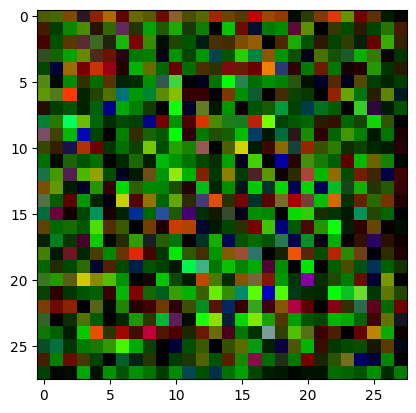

In [ ]:
inp = torch.randn(2,3,cfg.load_height,cfg.load_width).to(device) #As a sanity check, we define a random tensor with the same shape as an input image, to make sure that we can forward it to our network
out = model(inp)

visualize_nn_output(out, device)

The Train model function is the defined in the [train module from the project](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/train.py)


In [11]:
def run_model_on_image(model, device, dataset, image_index):
    model.eval()
    
    image = dataset[image_index]
    image = image["centered_mask_body"].to(device).unsqueeze(0)

    
    with torch.no_grad():
        output = model(image)

    return output


In [16]:
# For testing purposes (There are so many images) we can limit the number of loaded batches, 0 is no limit
cfg.max_batches = 0
model_store_unet_1 = model_store.ModelStore(model_name="unet_1")
model = smp.Unet(
    encoder_name="efficientnet-b0", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
).to(device)

trained_model = train_model(model, device, train_dataloader, test_dataloader, cfg.num_epochs, cfg.learning_rate, cfg.max_batches, model_store=model_store_unet_1)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training


  0%|          | 0/363 [00:00<?, ?it/s]

Epoch [1/1], Train Loss: 2.3595, Validation Loss: 1.6365
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


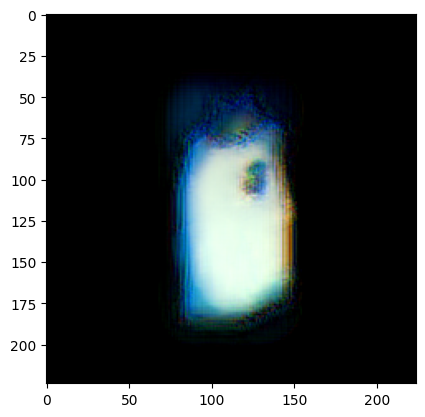

In [17]:
# model = torch.load('best5.pth')
out = run_model_on_image(model, device, train_dataset, 2)
visualize_nn_output(out, device)

In [ ]:
torch.save(model, 'best5.pth')

In [ ]:
# Hack for reloading an updated python module
from models.unet import Unet
import importlib
importlib.reload(Unet)